# Analysis of the LTM Toggle Switch

Below we will analyze the LTM toggle switch introduced by Kotula et al. in their 2004 PNAS paper:

http://www.pnas.org/content/111/13/4838.full.pdf



In [1]:
from sympy import *
import numpy as np
from IPython.display import display
init_printing()
%matplotlib inline
from ipywidgets import widgets, interact
#bokeh
from bokeh.plotting import Figure, output_notebook, show
from bokeh.layouts import widgetbox, column
from bokeh.models import CustomJS, ColumnDataSource, Slider

## Dilution Rate Analysis

We will first examine the dilution rate of an arbitrary protein in an E. coli cell undergoing division at a rate of one division per hour.

Dilution Rate = 1 binary division/60 min

$
x(t) = x_0 (1/2)^{t/60}
$

In absence of production, a given protein will decay as follows:

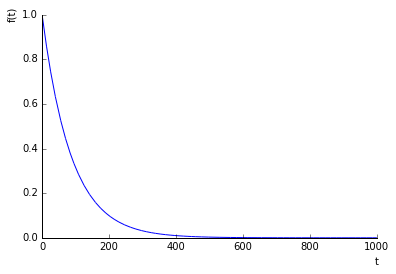

In [2]:
t = symbols("t", positive=1)
def plot_decay(duration=60):
    dilution = (1/2)**(t/duration)
    display(Eq(Symbol("x(t)"), dilution))
    plot(dilution, (t, 0, 1000))
plt=interact(plot_decay, duration=(1, 120, 5))

## Bistability Analysis
Below we perform bistability analysis akin to that performed by Gardner et al. ([2000](http://www.nature.com/nature/journal/v403/n6767/full/403339a0.html)). We provide interactivity (when this file is run in an __IPython Notebook__), in order to allow a greater degree of understanding of the geometric relationship between these equations. We demonstrate below the power of the hill-style equation to contend with cooperativity of binding, or multiple binding sites. Here we demonstrate a case of non-cooperative binding with 3 regulatory sites per promoter.

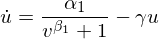

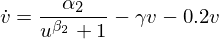

In [3]:
u, v, a1, a2, b1, b2, gamma, t = symbols("u v alpha_1 alpha_2 beta_1 beta_2 gamma t", positive=1)
dotu = a1/(1+v**b1) - gamma*u
dotv = a2/(1+u**b2) - gamma*v - .2*v
display(Eq(Symbol("\dot{u}"), dotu), Eq(Symbol("\dot{v}"), dotv))

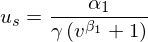

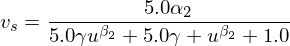

In [4]:
ustable = solve(dotu, u)[0]
display(Eq(Symbol("u_s"), ustable))
vstable = solve(dotv, v)[0]
display(Eq(Symbol("v_s"), vstable))

In [5]:
output_notebook()
def plot_stability(a1_val=.1, a2_val=.1, div_time=60):
    lf_ustable = lambdify(v, ustable.subs([(a1, a1_val), (gamma, ln(2)/div_time), (b1, 3)]))
    lf_vstable = lambdify(u, vstable.subs([(a2, a2_val), (gamma, ln(2)/div_time), (b2, 3)]))
    x_range = np.arange(0, 12, .05)
    x_range = np.hstack((.0001, x_range))
    source = ColumnDataSource(data=dict(x=x_range, u=lf_ustable(x_range), v=lf_vstable(x_range)))
    plt = Figure(plot_width=400, plot_height=400)
    plt.line('x', 'u', source=source, line_width=3, line_alpha=0.6, line_color="blue")
    plt.line('v', 'x', source=source, line_width=3, line_alpha=0.6, line_color="green")
    plt.xaxis.axis_label = '[u]'
    plt.yaxis.axis_label = '[v]'
    show(plt)
interact(plot_stability, a1_val=(.001, .6, .01), a2_val=(.001, .6, .01), div_time=(20, 120, 5), __manual=True)
plot_stability()

Loading BokehJS ...

In [6]:
plot_stability(a1_val=.01)

## Lambda Phage Switch Analysis

In the following analysis we will focus in upon the behaviour of the Lambda Phage switch, as described by the below image. The cI repressor will typically/preferentially bind to two of the three positions on the shared Promoter/RBS regions in the Phage Lambda switch; for this simple analysis we will ignore all binding to the third position. Likewise the Cro protein will typically repress one of the three sites; we will only consider single-site repression for this case.


<img src="http://www.nature.com/nchembio/journal/v7/n8/images/nchembio.611-F1.jpg" width=700></img>

_Image from ([Ptashne 2011](http://www.nature.com/nchembio/journal/v7/n8/full/nchembio.611.html))_

We model the QSSA dynamics of the above switch using a generalized Hill function, as shown below. 

## $H = \frac{1}{[(x/c)^\beta + 1]^\rho}$

Where beta = oligomerization constant; and lambda = # identical binding sites.

In the case of regulation of Cro expression, we utilize both a beta and lambda value of 2, given that there are two identical binding sites at which dimers bind. In the case of cI regulation, we only have dimerization, resulting in a beta of 2 and a lambda of 1.

$$\require{mhchem}$$

We begin by describing the dynamics of corepressor production:

$
\ce{U_{cro} ->[\alpha_{Ucro}] cro}
;\;
\ce{B_{cro} ->[\alpha_{Bcro}] cro}
;\;
\ce{BB_{cro} ->[\alpha_{BBcro}] cro}
\\[.2in]
\text{where: } \alpha_{Ucro} > \alpha_{Bcro} > \alpha_{BBcro}
\\[.2in]
\ce{2cI <=>[k_{d}][k_{-d}] cI_2}
;\;
\ce{{U}_{cro} + cI_2 <=>[k_{Bcro}][k_{-Bcro}] B_{cro}}
;\;
\ce{{B}_{cro} + cI_2 <=>[k_{BBcro}][k_{-BBcro}] BB_{cro}}
$

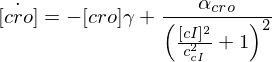

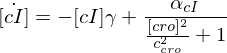

In [7]:
cro, cI, a_cro, a_cI, c_cro, c_cI, gamma, t = symbols("[cro] [cI] alpha_cro alpha_cI c_cro c_cI gamma t", positive=1)
dot_cro = a_cro/(1+(cI/c_cI)**2)**2 - gamma*cro
dot_cI = a_cI/(1+(cro/c_cro)**2) - gamma*cI
display(Eq(Symbol("\dot{[cro]}"), dot_cro), Eq(Symbol("\dot{[cI]}"), dot_cI))

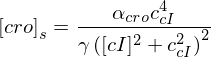

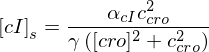

In [8]:
cro_stable = solve(dot_cro, cro)[0]
display(Eq(Symbol("{[cro]}_s"), cro_stable))
cI_stable = solve(dot_cI, cI)[0]
display(Eq(Symbol("{[cI]}_s"), cI_stable))

Loading BokehJS ...

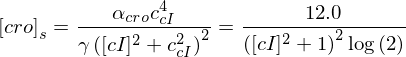

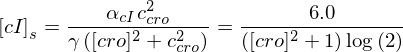

In [11]:
output_notebook()
def plot_stability(alpha_cro=.2, alpha_cI=.1, rep_cro=1, rep_cI=1, div_time=60):
    subs_cro = cro_stable.subs([(a_cro, alpha_cro), (c_cI, rep_cI), (gamma, ln(2)/div_time)])
    subs_cI = cI_stable.subs([(a_cI, alpha_cI), (c_cro, rep_cro), (gamma, ln(2)/div_time)])
    lf_cro_stable = lambdify(cI, subs_cro)
    lf_cI_stable = lambdify(cro, subs_cI)
    x_range = np.arange(1, 20, .05)
    x_range = np.hstack((np.arange(0, 1, .0001), x_range))
    source = ColumnDataSource(data=dict(x=x_range, u=lf_cro_stable(x_range), v=lf_cI_stable(x_range)))
    plt = Figure(plot_width=800, plot_height=400)
    plt.line('x', 'u', source=source, line_width=3, line_alpha=0.6, line_color="blue")
    plt.line('v', 'x', source=source, line_width=3, line_alpha=0.6, line_color="green")
    plt.xaxis.axis_label = '[cI]'
    plt.yaxis.axis_label = '[cro]'
    display(Eq(Symbol("{[cro]}_s"), Eq(cro_stable, subs_cro)))
    display(Eq(Symbol("{[cI]}_s"), Eq(cI_stable, subs_cI)))
    show(plt)
interact(plot_stability, 
         alpha_cro=(.01, .6, .01), alpha_cI=(.001, .6, .01),
         rep_cro=(.01, 4, .1), rep_cI=(.01, 4, .1),
         div_time=(20, 120, 5), __manual=1
)
plot_stability()